In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

gpytorch.functions.use_toeplitz = False
%matplotlib inline

In [2]:
n = 100
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x).cuda()
train_y = Variable((torch.sin(train_x.data[:, 0]) + torch.cos(train_x.data[:, 1])) * (2 * math.pi)).cuda()

In [3]:
class LatentFunction(gpytorch.AdditiveGridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=400, grid_bounds=[(0, 1)], n_components=2)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    
model = GPRegressionModel().cuda()

In [4]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(20):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/60 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

Iter 1/60 - Loss: 0.926
Iter 2/60 - Loss: 0.875
Iter 3/60 - Loss: 0.825
Iter 4/60 - Loss: 0.777
Iter 5/60 - Loss: 0.727
Iter 6/60 - Loss: 0.677
Iter 7/60 - Loss: 0.629
Iter 8/60 - Loss: 0.579
Iter 9/60 - Loss: 0.529
Iter 10/60 - Loss: 0.482
Iter 11/60 - Loss: 0.432
Iter 12/60 - Loss: 0.383
Iter 13/60 - Loss: 0.335
Iter 14/60 - Loss: 0.287
Iter 15/60 - Loss: 0.238
Iter 16/60 - Loss: 0.189
Iter 17/60 - Loss: 0.142
Iter 18/60 - Loss: 0.095
Iter 19/60 - Loss: 0.048
Iter 20/60 - Loss: 0.001


In [5]:
def plot_model_and_predictions(model):
    n = 10
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2)).cuda()
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)

    observed_pred = model(test_x)
    pred_labels = observed_pred.mean().view(n, n).data.cpu().numpy()
    
    test_y_actual = ((torch.sin(test_x.data[:, 0]) + torch.cos(test_x.data[:, 1])) * (2 * math.pi))
    test_y_actual = test_y_actual.cpu().numpy().reshape(n, n)
    delta_y = numpy.absolute(pred_labels - test_y_actual)
    
    def ax_plot(f, ax, y_labels, title):
        im = ax.imshow(y_labels)
        ax.set_title(title)
        f.colorbar(im)
    
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
    
    f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

    f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')
    
    return f

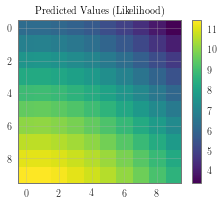

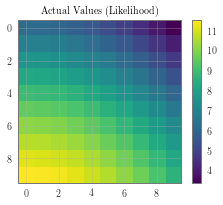

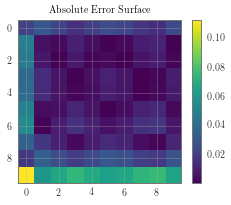

In [6]:
model.condition(train_x, train_y)
f = plot_model_and_predictions(model)